This problem set is provided to help you get used to PyTorch.

Only fill parts marked with "`Your code here`" comments, don't erase or change the rest.

<font color="red">**You are NOT ALLOWED to:**</font>
* use NumPy or any other tensor library except PyTorch;
* emulate PyTorch tensors (i.e. large arrays of numbers) with lists or tuples;
* emulate any tensor functionality with other libraries/loops/indexing if it's directly native to PyTorch. Example:

```python
x = torch.rand(1_000_000)

# Wrong: slow and unreadable
for idx in range(x.numel()):
    x[idx] = math.sqrt(x[idx])

# Correct
x.sqrt_()
```

# Homework 2, *part 1*
### (40 points total)

In this part only, you are <font color="red">**NOT ALLOWED**</font> to use any PyTorch submodules, including
* `torch.nn`,
* `torch.nn.functional` (in general, try to always avoid using it),
* `torch.optim`,
* `torch.utils.data`.

Instead, use only PyTorch core functions, such as `torch.avg_pool1d(x)` or `torch.no_grad()`. Where possible, use special operators syntax (e.g. `x @ y`, `x += 17`, `x[None]`) or tensor methods (e.g. `x.to(y)`, `x.prelu()`, `x.copy_(y)`).

**You are required** to format your notebook cells so that `Run All` command on a fresh notebook
* displays all the required plots in tasks 1 and 2;
* within 15 seconds, **reliably** trains your model in task 3 to the desired accuracy and reports the accuracy reached.

In [0]:
import numpy as np               # results verification during grading
import math                      # Pi

import matplotlib.pyplot as plt  # 2D plot in task 1
%matplotlib inline

import torch
assert torch.__version__ >= '1.3.0'

In [2]:
# Detect if we are in Google Colaboratory
try:
    import google.colab
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

from pathlib import Path
# Determine the locations of auxiliary libraries and datasets.
# `AUX_DATA_ROOT` is where 'notmnist.py', 'animation.py' and 'tiny-imagenet-2020.zip' are.
if IN_COLAB:
    google.colab.drive.mount("/content/drive")
    
    # Change this if you created the shortcut in a different location
    AUX_DATA_ROOT = Path("/content/drive/My Drive/Deep Learning 2020 -- Home Assignment 2")
    
    assert AUX_DATA_ROOT.is_dir(), "Have you forgot to 'Add a shortcut to Drive'?"
    
    import sys
    sys.path.insert(0, str(AUX_DATA_ROOT))
else:
    AUX_DATA_ROOT = Path(".")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# Import the custom libraries
from animation import Animation    # animations in task 2
from notmnist import load_notmnist # dataset for task 3

While learning PyTorch, you will have lots of questions, e.g.

* how to choose between `.sqrt()` and `.sqrt_()`,
* when to use `.view()` and how is it different from `.reshape()`,
* which `dtype` to use etc.

To find the answers, you are expected to study [documentation](https://pytorch.org/docs/stable/index.html) and google a lot.

If this is your first PyTorch experience, you may want to [start here](https://pytorch.org/tutorials/).

Quick documentation on functions and modules is available with `?` and `help()`, like so:

In [4]:
help(torch.sqrt)

Help on built-in function sqrt:

sqrt(...)
    sqrt(input, out=None) -> Tensor
    
    Returns a new tensor with the square-root of the elements of :attr:`input`.
    
    .. math::
        \text{out}_{i} = \sqrt{\text{input}_{i}}
    
    Args:
        input (Tensor): the input tensor.
        out (Tensor, optional): the output tensor.
    
    Example::
    
        >>> a = torch.randn(4)
        >>> a
        tensor([-2.0755,  1.0226,  0.0831,  0.4806])
        >>> torch.sqrt(a)
        tensor([    nan,  1.0112,  0.2883,  0.6933])



In [0]:
# to close the Jupyter help bar, press `Esc` or `q`
?torch.cat

## Task 1 (3 points)

**Use 64-bit floating point tensors for this task**.

$\rho(\theta)$ is defined in polar coordinate system:

$$\rho(\theta) = (1 + 0.9 \cdot \cos{8\theta} ) \cdot (1 + 0.1 \cdot \cos{24\theta}) \cdot (0.9 + 0.05 \cdot \cos {200\theta}) \cdot (1 + \sin{\theta})$$

1. Create a regular grid of 1000 values of $\theta$ between $-\pi$ and $\pi$.
2. Compute $\rho(\theta)$ at these points.
3. Convert the result into Cartesian coordinates ([see here how](http://www.mathsisfun.com/polar-cartesian-coordinates.html)).

In [0]:
theta = torch.linspace(-np.pi, np.pi, 1000) # (1) Your code here
assert theta.shape == (1000,)

rho = (1 + 0.9*torch.cos(8*theta)) * (1 + 0.1*torch.cos(24*theta)) * (0.9 + 0.05*torch.cos(200*theta)) * (1 + torch.sin(theta)) # (2) Your code here
assert torch.is_same_size(rho, theta)

# x -- theta, y -- rho
x = rho * torch.cos(theta) # (3) Your code here
y = rho * torch.sin(theta) # (3) Your code here

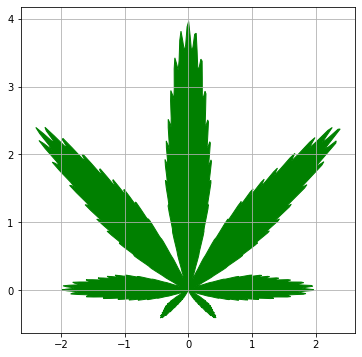

In [7]:
# Run this cell and make sure the plot is correct
plt.figure(figsize=(6,6))
plt.fill(x, y, color='green')
plt.grid()

In [8]:
assert \
    np.allclose(x.sum(), -1.9854999999997989, atol=1e-4) and \
    np.allclose(y.mean(), 0.44955, atol=1e-4), \
    "Task 1: you've made an error somewhere"
print("Task 1: well done!")

Task 1: well done!


## Task 2 (7 points)

We will implement [Conway's Game of Life](https://en.wikipedia.org/wiki/Conway's_Game_of_Life) in PyTorch.

![img](https://cdn.tutsplus.com/gamedev/authors/legacy/Stephane%20Beniak/2012/09/11/Preview_Image.png)

In case you skipped the above hyperlink, here are the rules:
* You have a 2D grid of cells, where each cell is "alive" or "dead" (has a value of `1` or `0` respectively).
* At each step in time, the so-called "generation update" happens:
  * any alive cell that has 2 or 3 neighbors survives, otherwise (0, 1 or 4+ neighbors) it dies;
  * any cell with exactly 3 neighbors becomes alive if it was dead.

You are given a reference numpy implementation of the generation update. Your task is to convert it to PyTorch. Try to avoid datatype conversions.

In [0]:
from scipy.signal import correlate2d as conv2d

def game_of_life_update_numpy(alive_map):
    """
    Game of Life update function.
    
    alive_map:
        `numpy.ndarray`, ndim == 2, dtype == `np.int64`
        The game map containing 0s (dead) an 1s (alive).
    """
    # Count neighbours with convolution
    conv_kernel = np.array([[1,1,1],
                            [1,0,1],
                            [1,1,1]], dtype=np.int64)
    
    num_alive_neighbors = conv2d(alive_map, conv_kernel, mode='same')
    
    # Apply game rules
    born = np.logical_and(num_alive_neighbors == 3, alive_map == 0)
    survived = np.logical_and(np.isin(num_alive_neighbors, [2,3]), alive_map == 1)
    
    np.copyto(alive_map, np.logical_or(born, survived))

In [0]:
def game_of_life_update_torch(alive_map):
    """
    PyTorch version of `game_of_life_update_numpy`.
    
    alive_map:
        `torch.tensor`, ndim == 2, dtype == `torch.int64`
        The game map containing 0s (dead) an 1s (alive).
    """
    # Your code here
    # Count neighbours with convolution
    conv_kernel = torch.tensor([[1,1,1],
                                [1,0,1],
                                [1,1,1]], dtype=torch.int64)
    
    num_alive_neighbors = torch.conv2d(alive_map[None,None,:,:], conv_kernel[None,None,:,:], padding=1).squeeze()

    # Apply game rules
    born = (num_alive_neighbors == 3) & (alive_map == 0)
    survived = ((num_alive_neighbors == 3) | (num_alive_neighbors == 2)) & (alive_map == 1)

    mask = born | survived
    mask.to(torch.int64)
    alive_map.copy_(mask)

In [11]:
for _ in range(10):
    # Generate a random initial map
    alive_map_numpy = np.random.choice([0, 1], p=(0.5, 0.5), size=(100, 100))
    alive_map_torch = torch.from_numpy(alive_map_numpy).clone()

    game_of_life_update_numpy(alive_map_numpy)
    game_of_life_update_torch(alive_map_torch)

    # Results must be identical
    assert np.allclose(alive_map_torch.numpy(), alive_map_numpy), \
        "Your PyTorch implementation doesn't match numpy_update."

print("Task 2: well done!")

Task 2: well done!


In [12]:
animation = Animation(monochrome=True)

# Initialize game field
np.random.seed(666)
alive_map = np.random.choice([0, 1], size=(100, 100))
alive_map = torch.from_numpy(alive_map)

for _ in range(101):
    animation.add_image((alive_map * 255).byte().numpy()[:, :, None])
    game_of_life_update_torch(alive_map)

animation.display()

In [13]:
animation = Animation(monochrome=True)

# A fun setup for your amusement
alive_map = np.arange(100) % 2 + np.zeros((100, 100), dtype=np.int64)
alive_map[48:52, 50] = 1

alive_map = torch.from_numpy(alive_map)

for _ in range(150):
    animation.add_image((alive_map * 255).byte().numpy()[:, :, None])
    game_of_life_update_torch(alive_map)

animation.display()

More fun with Game of Life: [video](https://www.youtube.com/watch?v=C2vgICfQawE)

## Task 3 (30 points)

You have to solve yet another character recognition problem: *notMNIST* dataset of 10 letters and ~14 000 train samples.

For this, we ask you to build a multilayer perceptron (*i.e. a neural network of linear layers*) from scratch using **low-level** PyTorch interface.

Requirements:
1. at least 82% validation accuracy,
2. at least 2 linear layers,
3. no convolutions,
3. use [softmax followed by categorical cross-entropy](https://gombru.github.io/2018/05/23/cross_entropy_loss/).

Tips:

* Don't use the structures from homework 1 (`Sequential`, `.forward()` etc.). I suggest that your `NeuralNet.predict()` consists of 5-7 lines.
* Pick random batches (either shuffle data before each epoch or sample each batch randomly).
* Do not initialize weights with zeros ([learn why](https://stats.stackexchange.com/questions/27112/danger-of-setting-all-initial-weights-to-zero-in-backpropagation)). Gaussian noise with small variance will do.
* 50 hidden neurons and a sigmoid nonlinearity will do for a start. Many ways to improve.
* To improve accuracy, consider changing layers' sizes, nonlinearities, optimization methods, weights initialization.
* Don't use GPU yet.

Happy googling!

In [0]:
import matplotlib.pyplot as plt
from IPython import display
import torch
import numpy as np
from tqdm import tqdm
from notmnist import load_notmnist # dataset for task 3

import time

In [15]:
letters = 'ABCDEFGHIJ'
X_train, y_train, X_val, y_val = map(torch.tensor, load_notmnist(letters=letters))
X_train.squeeze_()
X_val.squeeze_();

Parsing... (it's OK if <10 images are broken)
Found broken image: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Found broken image: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


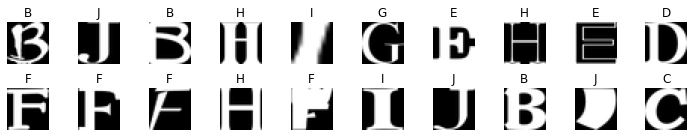

In [16]:
fig, axarr = plt.subplots(2, 10, figsize=(10, 2))

for idx, ax in enumerate(axarr.ravel()):
    ax.imshow(X_train[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(letters[y_train[idx]])

fig.tight_layout()

In [17]:
X_train = X_train.reshape(-1, X_train.size(1)**2)
X_val = X_val.reshape(-1, X_val.size(1)**2)
X_train.size()

torch.Size([14043, 784])

In [0]:
np.random.seed(666)
torch.manual_seed(666);

The cell below has an example layout for encapsulating your neural network. Feel free to modify the interface if you need to (add arguments, add return values, add methods etc.). For example, you may want to add a method `do_gradient_step()` that executes one optimization algorithm (SGD / Adadelta / Adam / ...) step.

In [0]:
# source: seminar_tensorboard.ipynb, utils.py https://drive.google.com/uc?id=1O3QWBKrqA7s8nIGzhKMIz-YNK1-jzwml
def plot_loss_and_accuracy(loss_history, train_accuracy, val_accuracy, clear_output=True):
    if clear_output:
        display.clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    if loss_history:
        ax[0].semilogy(loss_history)
        ax[0].set_title('Training loss')
        ax[0].set_xlabel('# batches processed')
        ax[0].set_ylabel('loss value')
    
    if len(train_accuracy) > 0:
        ax[1].plot(train_accuracy, '*-b', label='train')
        ax[1].plot(val_accuracy, '*-r', label='test')
        ax[1].set_title('Accuracy')
        ax[1].legend()
        ax[1].set_xlabel('# epochs processed')
        ax[1].set_ylabel('accuracy value')
    
    plt.show()

In [0]:
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.size(0)
        
    # Shuffle at the start of epoch
    indices = torch.arange(n_samples)
    indices = indices[torch.randperm(indices.size(0))]
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)        
        batch_idx = indices[start:end]
        yield X[batch_idx], Y[batch_idx]

In [0]:
def compute_accuracy(logits, y_true):
    y_pred = torch.argmax(logits, dim=1)
    return (y_pred == y_true).float().mean()

In [0]:
def accuracy(model, images, labels):
    """
    model:
        `NeuralNet`
    images:
        `torch.tensor`, shape == `N x height x width`, dtype == `torch.float32`
    labels:
        `torch.tensor`, shape == `N`, dtype == `torch.int64`
        Class indices for each sample in `images`.
    
    return:
    value:
        `float`
        The fraction of samples from `images` correctly classified by `model`.
        `0 <= value <= 1`.
        
    """
    # Your code here
    logits = model.forward(images)
    y_pred = torch.argmax(logits, dim=1)
    return (y_pred == labels).float().mean()

In [0]:
class Neural_Net():
    def __init__(self, input_size, num_classes, num_layers, hidden_size=50, lr=1e-2):
        self.inputSize = input_size
        self.outputSize = num_classes
        self.hiddenSize = hidden_size
        self.num_layers = num_layers
        self.W = []
        self.b = []
        self.gamma = 0.9
        self.p = 0.01
        
        # Do not initialize weights with zeros (learn why). Gaussian noise with small variance will do.
        self.W.append(torch.randn((self.inputSize, self.hiddenSize), requires_grad=True))
        self.b.append(torch.randn((self.hiddenSize), requires_grad=True))
        
        for i in range(num_layers - 2):
            self.W.append(torch.randn((self.hiddenSize, self.hiddenSize), requires_grad=True))
            self.b.append(torch.randn((self.hiddenSize), requires_grad=True))
        
        self.W.append(torch.randn((self.hiddenSize, self.outputSize), requires_grad=True))
        self.b.append(torch.randn((self.outputSize), requires_grad=True))
            
        for w in self.W:
            w.data *= 0.1
        for b in self.b:
            b.data *= 0.1
        
        self.loss = 0
        self.lr = lr

    def softmax_crossentropy(self, logits, labels):
        logits_for_answers = logits[torch.arange(logits.size(0)), labels]
        xentropy = -logits_for_answers + torch.log(torch.sum(torch.exp(logits), axis=-1))
        return xentropy.mean()

    def forward(self, z, is_train=False):
        for i, (w, b) in enumerate(zip(self.W[:-1], self.b[:-1])):
            z = torch.dropout(z, self.p, is_train)
            z = z @ w + b
            z = torch.tanh(z)
            
        z = torch.dropout(z, self.p, is_train)
        z = z @ self.W[-1] + self.b[-1]
        z = torch.softmax(z, dim=1)
        return z
        
    def train(self, X, y):
        y_pred = self.forward(X, is_train=True)
        self.loss = self.softmax_crossentropy(y_pred, y.long())
        self.loss.backward()

        for i in range(self.num_layers):
            self.W[i].data -= self.lr * self.W[i].grad.data
            self.b[i].data -= self.lr * self.b[i].grad.data
            self.W[i].grad.zero_()
            self.W[i].grad.detach_()
            self.b[i].grad.zero_()
            self.b[i].grad.detach_()

        return self.loss, y_pred

In [0]:
def train(model, num_epochs=2, batch_size=500):
    train_loss = []
    train_accuracy = []
    val_accuracy = []
    
    for epoch in tqdm(range(num_epochs)):
        start_time = time.time()
        train_accuracy_batch = []

        for batch_no, (X_batch, y_batch) in tqdm(enumerate(get_batches((X_train, y_train), batch_size))):
            # main cycle
            loss, logits = model.train(X_batch, y_batch)

            # only for statistics:
            if batch_no % 10 == 0:
                train_loss.append(loss.item())
                accuracy = compute_accuracy(logits, y_batch)
                train_accuracy_batch.append(accuracy.item()) # train accuracy of one batch, every 10 batches
        
        train_accuracy_overall = np.mean(train_accuracy_batch) * 100 # mean train accuracy over 1 epoch in %
        train_accuracy.append(train_accuracy_overall.item())

        # every epoch we test validation sample
        val_accuracy_batch = []
        for X_batch, y_batch in tqdm(get_batches((X_val, y_val), batch_size)):
            logits = model.forward(X_batch)

            accuracy = compute_accuracy(logits, y_batch) # val accuracy of one batch
            val_accuracy_batch.append(accuracy.item())

        val_accuracy_overall = np.mean(val_accuracy_batch) * 100 # mean val accuracy over batches in %
        val_accuracy.append(val_accuracy_overall)

        plot_loss_and_accuracy(train_loss, train_accuracy, val_accuracy, clear_output=True)

    return train_accuracy_overall, val_accuracy_overall

In [0]:
model = Neural_Net(X_train.size(1), num_classes=10, num_layers=5, hidden_size=50, lr=0.1)

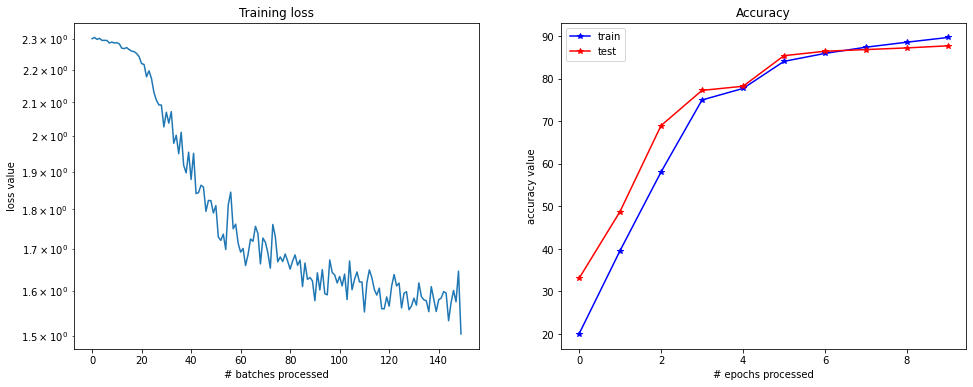

100%|██████████| 10/10 [00:09<00:00,  1.09it/s]

CPU times: user 8.69 s, sys: 211 ms, total: 8.9 s
Wall time: 9.17 s


In [26]:
%%time
torch.set_num_threads(1)
# Your code here (train the model)
train_accuracy, val_accuracy = train(model, num_epochs=10, batch_size=100)

In [27]:
train_accuracy = accuracy(model, X_train, y_train) * 100
val_accuracy = accuracy(model, X_val, y_val) * 100
print("Training accuracy: %.2f, validation accuracy: %.2f" % (train_accuracy, val_accuracy))

assert val_accuracy >= 82.0, "You have to do better"
print("Task 3: well done!")

Training accuracy: 89.55, validation accuracy: 87.80
Task 3: well done!
